In [6]:
# Author: Marc Padrós Jiménez
# Bachelor's Final Degree Project
# Date: 25th April 2022

from fastai.vision.all import *
import cv2
import numpy as np

from lungs_detection_library import * 
import sys
sys.path.append("..")
from Grid_algorithm.grid_bboxes_library import * 

import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Get the detected predicted lungs

In [7]:
lungsDetectorModel = setupLearner()

In [10]:
predictedLungs = lungsDetectorModel.get_preds()
# predictedLungs = tuple with 2 elements
# 1st element of the tuple is a TensorBase
# 2nd element of the tuple is a TensorBBox of size nValidationImages x 8 (8 = total number of coords. for image)
# the first 4 coords of a TensorBBox element refer to the bbox of the left lung
# the last 4 coords of a TensorBBox element refer to the bbox of the right lung 

predictedLungs = ((predictedLungs[1] + 1) / 2).numpy()
# (preds + 1) is used to make negative predictions turn into positive 
# NOTE: Why is ((preds + 1) divided by 2? are the predictions too big (I GET THAT IT'S A NORMALIZATION OF PREDICTIONS)
# numpy() converts to a ndarray Example size: (83,4)

Get the grids related to pleural effusion

In [13]:
predictedLungsPaths = lungsDetectorModel.dls.valid_ds.items

gridsPath = "gridsPleuralEffusion/"

for i in range(len(predictedLungsPaths)):
    imageFullName = predictedLungsPaths[i].name # it contains also the extension
    
    imagePath = '../Lungs_detection/Datasets/roi_detection_subset/train_val/' + imageFullName

    imgRes = cv2.imread(imagePath) 

    # NOTE: I read again the BW image that was previously readen because 
    # I need it as an array, not as a PILImage type to be able to access the pixels values 
    imgOri = cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE) 

    leftLung = predictedLungs[i][0:4] * [imgOri.shape[0], imgOri.shape[1], imgOri.shape[0], imgOri.shape[1]]
    # convert a TensorBBox to a numpy array, so that, we can access each coord as a flot
    rightLung = predictedLungs[i][4:8] * [imgOri.shape[0], imgOri.shape[1], imgOri.shape[0], imgOri.shape[1]]

    gridsLungLeft = gridBbox(leftLung, imgRes, imgOri, 3, 3) # grid bbox left
    gridsLungRight = gridBbox(rightLung, imgRes, imgOri, 3, 3) # grid bbox right

    #plt.imshow(imgRes)

    #plt.figure()

    #f, axarr = plt.subplots(1,2) 

    imageName = predictedLungsPaths[i].stem # it doesn't contain the extension 

    gridsImagePath = gridsPath + imageName + '/' 

    os.makedirs(gridsImagePath, exist_ok=True)

    #axarr[0].imshow(gridsLungLeft[6])
    cv2.imwrite(os.path.join(gridsImagePath,'D3.png'), gridsLungLeft[6])

    #axarr[1].imshow(gridsLungRight[8])
    cv2.imwrite(os.path.join(gridsImagePath,'E3.png'), gridsLungRight[8])

Classify grids as normal or pleural effusion

In [ ]:
def img_to_numpy_array(img_object):
    im_width = 40
    im_height = 40
    img = load_img(img_object, grayscale=True)
    img.thumbnail((im_width, im_height)) # scale the image to a size not larger than im_width x im_height
    x = img_to_array(img)  
    x = np.resize(x,(1,40, 40, 1)) # I have to call resize() instead of reshape() because img.thumbnail doesn't return a 40x40 image
    return x

In [ ]:
def plot_figures(figures, n_rows, n_cols):

    fig, axes = plt.subplots(ncols = n_cols, 
                                 nrows = n_rows)
    for ind, title in enumerate(figures):
        axes.ravel()[ind].imshow(figures[title], 
                                     cmap=plt.gray())
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout()

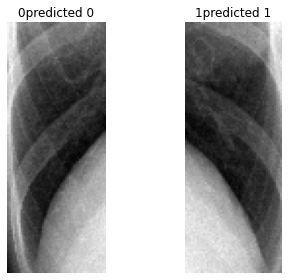

In [ ]:
# Load the learned model from the Github repo: https://github.com/ashok133/Pleural-Effusion-Detection

model = keras.models.load_model("pleural_effusion_model.h5")

test_effusion_dir = gridsImagePath

total_effusion_test_images = [f for f in os.listdir(test_effusion_dir) if os.path.isfile(os.path.join(test_effusion_dir, f))]

prediction_effusion = []

# Create a CSV file

for i in range(len(total_effusion_test_images)):
  effusion_img_path = test_effusion_dir + total_effusion_test_images[i]
  img1 = mpimg.imread(effusion_img_path)
  effusion_array = img_to_numpy_array(effusion_img_path)
  prediction_effusion.append(1 if model.predict(effusion_array)[0][0] > 0.5 else 0)
  # Update CSV file
  
